In [1]:
import pandas as pd
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import K2Score

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.readwrite import BIFReader, BIFWriter

In [3]:
characteristics_df = pd.read_csv('data/characteristics_prepped.csv', encoding='latin1')
places_df = pd.read_csv('data/places_prepped.csv', encoding='latin1')
users_df = pd.read_csv('data/users_prepped.csv', encoding='latin1')
vehicles_df = pd.read_csv('data/vehicles_prepped.csv', encoding='latin1')

## Vehicles + users merge

Vechicles and users table might contain multiple rows for the same Num_Acc id. (Because there might be multiple people or vehicles involved in the accident)

In [4]:
vehicles_df.shape

(1433389, 8)

In [5]:
users_df.shape

(1876005, 13)

In [6]:
vehicles_users_df = pd.merge(vehicles_df, users_df, on='Num_Acc', how='outer', suffixes=('_vehicles', '_users'))

Filter rows that that contains a user-vehicle pair that does not match.

In [7]:
vehicles_users_df = vehicles_users_df[vehicles_users_df['num_veh_vehicles'] == vehicles_users_df['num_veh_users']]

In [8]:
vehicles_users_df.head()

,Num_Acc,Occupants,Mobile Obstacle,Shock,num_veh_vehicles,Vehicle_Category,Fix_obstacle_type,Maneuver_category,Seat,User type,Severity,Sex,Trip,Pedestrian location,Pedestrian action,Pedestrian alone,num_veh_users,Age_range,Safety equipment existence,Safety equipment use
0,200500000001,1,2.0,1.0,A01,8,0,1,1,1,2,1,1,0,0,0,A01,3,1,1
7,200500000001,1,2.0,8.0,B02,8,0,1,1,1,3,2,3,0,0,0,B02,3,1,1
8,200500000001,1,2.0,8.0,B02,8,0,1,2,2,1,1,0,0,0,0,B02,3,1,1
9,200500000001,1,2.0,8.0,B02,8,0,1,4,2,1,1,0,0,0,0,B02,0,3,1
10,200500000001,1,2.0,8.0,B02,8,0,1,5,2,1,1,0,0,0,0,B02,0,1,1


In [9]:
vehicles_users_df['num_veh_vehicles'].isna().sum()

0

In [10]:
vehicles_users_df['num_veh_users'].isna().sum()

0

In [11]:
vehicles_users_df.drop(['num_veh_users', 'num_veh_vehicles'], axis=1, inplace=True)

In [12]:
vehicles_users_df.shape

(1875983, 18)

There are no vehicles without users and no users without vehicles.

## Characteristics + places merge

In [13]:
places_df.shape

(839985, 11)

In [14]:
characteristics_df.shape

(839985, 11)

In [15]:
characteristics_places_df = pd.merge(places_df, characteristics_df, on='Num_Acc', how='inner')

In [16]:
characteristics_places_df.shape

(839985, 21)

## Merge all

In [17]:
merged_df = pd.merge(characteristics_places_df, vehicles_users_df, on='Num_Acc', how='inner')

In [18]:
merged_df.shape

(1875983, 38)

In [19]:
merged_df.head()

,Num_Acc,road_type,traffic_type,num_lanes,bike_lane_type,terrain_type,curve_type,condition,infrastructure,situ,...,User type,Severity,Sex,Trip,Pedestrian location,Pedestrian action,Pedestrian alone,Age_range,Safety equipment existence,Safety equipment use
0,201600000001,3.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,...,1,1,2,0,0,0,0,3,1,1
1,201600000001,3.0,2.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0,...,1,3,1,9,0,0,0,1,2,1
2,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,1,3,1,5,0,0,0,4,1,1
3,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,2,3,1,0,0,0,0,1,1,1
4,201600000002,3.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,...,2,3,2,0,0,0,0,4,1,1


In [20]:
merged_df.drop('Num_Acc', axis=1, inplace=True)
merged_df.drop('Municipality', axis=1, inplace=True)
merged_df.drop('Date', axis=1, inplace=True)

In [21]:
merged_df = merged_df.apply(pd.to_numeric, downcast="integer")

## Bayes model

In [22]:
merged_df.nunique()

road_type                       7
traffic_type                    5
num_lanes                      11
bike_lane_type                  4
terrain_type                    5
curve_type                      5
condition                      10
infrastructure                  8
situ                            6
school                          3
Lighting                        5
Localisation                    2
Intersection                   10
Atmospheric conditions          9
Collision type                  7
Department                    101
Holiday                         2
Time_of_day                     4
Occupants                       5
Mobile Obstacle                 7
Shock                          10
Vehicle_Category                8
Fix_obstacle_type               5
Maneuver_category               7
Seat                           10
User type                       4
Severity                        4
Sex                             2
Trip                            7
Pedestrian loc

In [23]:
scoring_method = K2Score(data=merged_df)
est = HillClimbSearch(data=merged_df)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

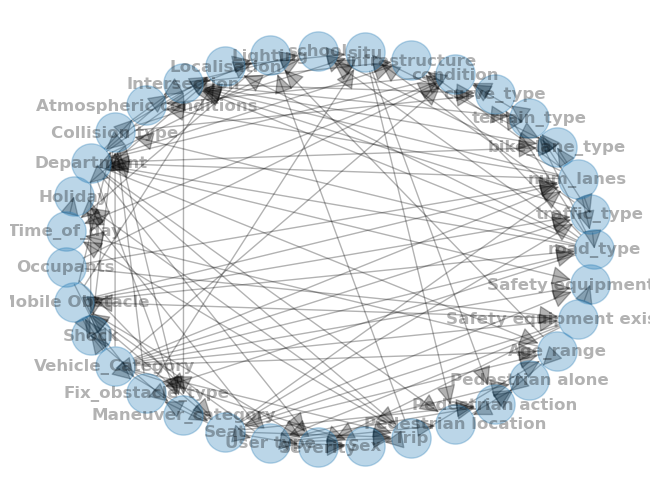

In [24]:
nx.draw_circular(
    estimated_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold"
)

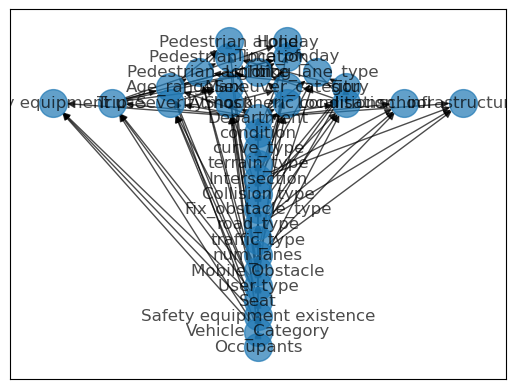

In [25]:
G = estimated_model
#From networkx tutorial for graphing topological order
for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')

plt.figure(10)
nx.draw_networkx(G, pos=pos, with_labels=True, arrowsize=10, node_size=400, alpha=0.7)
plt.show()

In [26]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork(estimated_model)

In [27]:
from pgmpy.estimators import MaximumLikelihoodEstimator
model.fit(merged_df, estimator=MaximumLikelihoodEstimator)

In [28]:
model.cpds

[<TabularCPD representing P(road_type:7 | Mobile Obstacle:7, Vehicle_Category:8, num_lanes:11, traffic_type:5) at 0x215b7b5fb90>,
 <TabularCPD representing P(traffic_type:5 | Mobile Obstacle:7, Seat:10, Vehicle_Category:8, num_lanes:11) at 0x215b44f6d10>,
 <TabularCPD representing P(num_lanes:11 | Mobile Obstacle:7, Occupants:5, Seat:10, Vehicle_Category:8) at 0x215b7eba290>,
 <TabularCPD representing P(bike_lane_type:4 | Department:101, Intersection:10, num_lanes:11, situ:6) at 0x215b8943b50>,
 <TabularCPD representing P(terrain_type:5 | Intersection:10, num_lanes:11, road_type:7, traffic_type:5) at 0x215b8943650>,
 <TabularCPD representing P(curve_type:5 | Collision type:7, Intersection:10, road_type:7, terrain_type:5) at 0x215b8941510>,
 <TabularCPD representing P(condition:10 | Occupants:5, Vehicle_Category:8, curve_type:5, terrain_type:5) at 0x215b8942490>,
 <TabularCPD representing P(infrastructure:8 | Department:101, Intersection:10, num_lanes:11, road_type:7) at 0x215b8941ed0>,

In [ ]:
writer = BIFWriter(model)
writer.write_bif(filename='model.bif')

In [30]:
model.save("model.bif", filetype="bif")

In [54]:
model

In [53]:
from pgmpy.readwrite import UAIWriter

writer = UAIWriter(model)


KeyboardInterrupt



In [ ]:
writer.write_uai('model.uai')

### Min-max hill climb

In [140]:
mmest = MmhcEstimator(data=merged_df[merged_df.columns[0:6]])
model = mmest.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [139]:
merged_df.columns

Index(['road_type', 'traffic_type', 'num_lanes', 'bike_lane_type',
       'terrain_type', 'curve_type', 'condition', 'infrastructure', 'situ',
       'school', 'Lighting', 'Localisation', 'Intersection',
       'Atmospheric conditions', 'Collision type', 'Department', 'Holiday',
       'Time_of_day', 'Occupants', 'Mobile Obstacle', 'Shock',
       'Vehicle_Category', 'Fix_obstacle_type', 'Maneuver_category', 'Seat',
       'User type', 'Severity', 'Sex', 'Trip', 'Pedestrian location',
       'Pedestrian action', 'Pedestrian alone', 'Age_range',
       'Safety equipment existence', 'Safety equipment use'],
      dtype='object')